In [1]:
import pandas as pd
import numpy as np

from darts import TimeSeries
from darts.models import (NaiveSeasonal,NaiveDrift,RNNModel,Prophet,ExponentialSmoothing,ARIMA,AutoARIMA,TCNModel,TransformerModel,Theta,FFT)
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.dataprocessing.transformers import Scaler

import prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from math import sqrt

Importing plotly failed. Interactive plots will not work.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dark_palette = ['#3E4095','#9F3E4B','#4D9458','#5D4774','#ADAA27']
light_palette = ['#A6ABE4','#E3A3A7','#B2D9B8','#C6B9CF','#D9D89F']

In [4]:
def prepararDatos(data, ds_nombre, y_nombre):

    # toma el dataframe, el nombre de la variable x (la fecha) y la y (la variable a ajustar)
    # retorna tres timeseries data, train y test

    train = data[:int(0.85*(len(data)))].iloc[1:]
    test = data[int(0.85*(len(data))):]

    # Se crea la serie de tiempo de train y test para las diferentes predicciones
    # tr_{columna} = dataframe de train
    # ts_{columna} = dataframe de test
    # data_{columna} = dataframe de data
    # trs_{columna} = serie de tiempo de train
    # tss_{columna} = serie de tiempo de test 
    # datas_{columna} = serie de tiempo de data

    tr = pd.DataFrame({
        'ds': train[ds_nombre],
        'y': train[y_nombre]
    })
    ts = pd.DataFrame({
        'ds': test[ds_nombre],
        'y': test[y_nombre]
    })
    da = pd.DataFrame({
        'ds': data[ds_nombre],
        'y': data[y_nombre]
    })

    trs = TimeSeries.from_dataframe(tr, 'ds', 'y')
    tss = TimeSeries.from_dataframe(ts, 'ds', 'y')
    das = TimeSeries.from_dataframe(da, 'ds', 'y')

    da.set_index('ds',inplace=True)
    tr.set_index('ds',inplace=True)
    ts.set_index('ds',inplace=True)

    return [da, das, tr, trs, ts, tss]

In [5]:
df = pd.read_excel('datos.xlsx')
df.replace(0, np.nan, inplace=True)

In [6]:
data, data_ts, train, train_ts, test, test_ts = prepararDatos(df, 'mes', 'v_total')

In [7]:

def modelosDarts(train_ts, test_ts):

    resultados = pd.DataFrame(columns=['Modelo','RMSE','MSE','MAE','R2'])
    predicciones = pd.DataFrame()

    modelos_nombres = [
                'EXS: Simple'
                ,'EXS: Holt (Add)'
                ,'EXS: Holt (Mult)'
                ,'EXS: Winter (Add,Add)'
                ,'EXS: Winter (Mult,Add)'
                ,'EXS: Winter (Mult,Mult)'
                ,'AutoARIMA'
                ,'Prophet'
                ,'RNN'
                ,'Fast Fourier Transform (FFT)'
                ]
    modelos = [ExponentialSmoothing()
                ,ExponentialSmoothing(trend=ModelMode.ADDITIVE)
                ,ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE) 
                ,ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE,seasonal_periods=12)
                ,ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=SeasonalityMode.ADDITIVE,seasonal_periods=12) 
                ,ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, seasonal=SeasonalityMode.MULTIPLICATIVE,seasonal_periods=12) 
                ,AutoARIMA(random_state = 10)
                ,Prophet()
                ,RNNModel( model='LSTM',
                    input_chunk_length=10,
                    output_chunk_length=1,
                    hidden_dim=25,
                    n_rnn_layers=3,
                    dropout=0.2,
                    batch_size=2,
                    n_epochs=150,
                    optimizer_kwargs={'lr': 1e-3},
                    log_tensorboard=True,
                    random_state=42)
                ,FFT()
                ]


    transformer = Scaler()
    train_transformed = transformer.fit_transform(train_ts)

    for i in range(len(modelos)) :
        
        model = modelos[i]
        model.fit(train_ts if modelos_nombres[i] != 'RNN' else train_transformed)
        
        prediction = model.predict(len(test_ts))
        prediction = prediction.pd_dataframe() if modelos_nombres[i] != 'RNN' else transformer.inverse_transform(prediction).pd_dataframe()

        rmse = sqrt(mean_squared_error(test_ts.pd_dataframe(), prediction))
        mse = mean_squared_error(test_ts.pd_dataframe(), prediction)
        mae = mean_absolute_error(test_ts.pd_dataframe(), prediction)
        r2 = r2_score(test_ts.pd_dataframe(), prediction)

        row = [modelos_nombres[i], rmse, mse, mae, r2]
        predicciones[modelos_nombres[i]] = prediction

        resultados.loc[len(resultados.index)] = row

    return [resultados, predicciones]

In [8]:
resultados, predicciones = modelosDarts(train_ts, test_ts)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
21:16:50 - cmdstanpy - INFO - Chain [1] start processing
21:16:50 - cmdstanpy - INFO - Chain [1] done processing
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 13.2 K
4 | V             | Linear           | 26    
---------------------------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
# predicciones2 = predicciones.reset_index()#inplace=True)#predicciones.iloc[:,0]
# predicciones2['index'] = predicciones2.reset_index().index + test.index.start
# predicciones2.set_index('index', inplace=True)
# predicciones2



In [10]:
resultados

,Modelo,RMSE,MSE,MAE,R2
0,EXS: Simple,2.136312e+06,4.563830e+12,2.009899e+06,-5.927777e+00
1,EXS: Holt (Add),2.136312e+06,4.563830e+12,2.009899e+06,-5.927777e+00
2,EXS: Holt (Mult),1.570497e+06,2.466462e+12,1.486527e+06,-2.744026e+00
3,"EXS: Winter (Add,Add)",2.136312e+06,4.563830e+12,2.009899e+06,-5.927777e+00
4,"EXS: Winter (Mult,Add)",1.570497e+06,2.466462e+12,1.486527e+06,-2.744026e+00
5,"EXS: Winter (Mult,Mult)",1.759491e+09,3.095808e+18,7.101875e+08,-4.699357e+06
6,AutoARIMA,1.364585e+06,1.862093e+12,1.095531e+06,-1.826610e+00
7,Prophet,6.926854e+05,4.798131e+11,5.889600e+05,2.716560e-01
8,RNN,2.695435e+06,7.265371e+12,2.381385e+06,-1.002865e+01
9,Fast Fourier Transform (FFT),2.947831e+06,8.689706e+12,2.836414e+06,-1.219075e+01


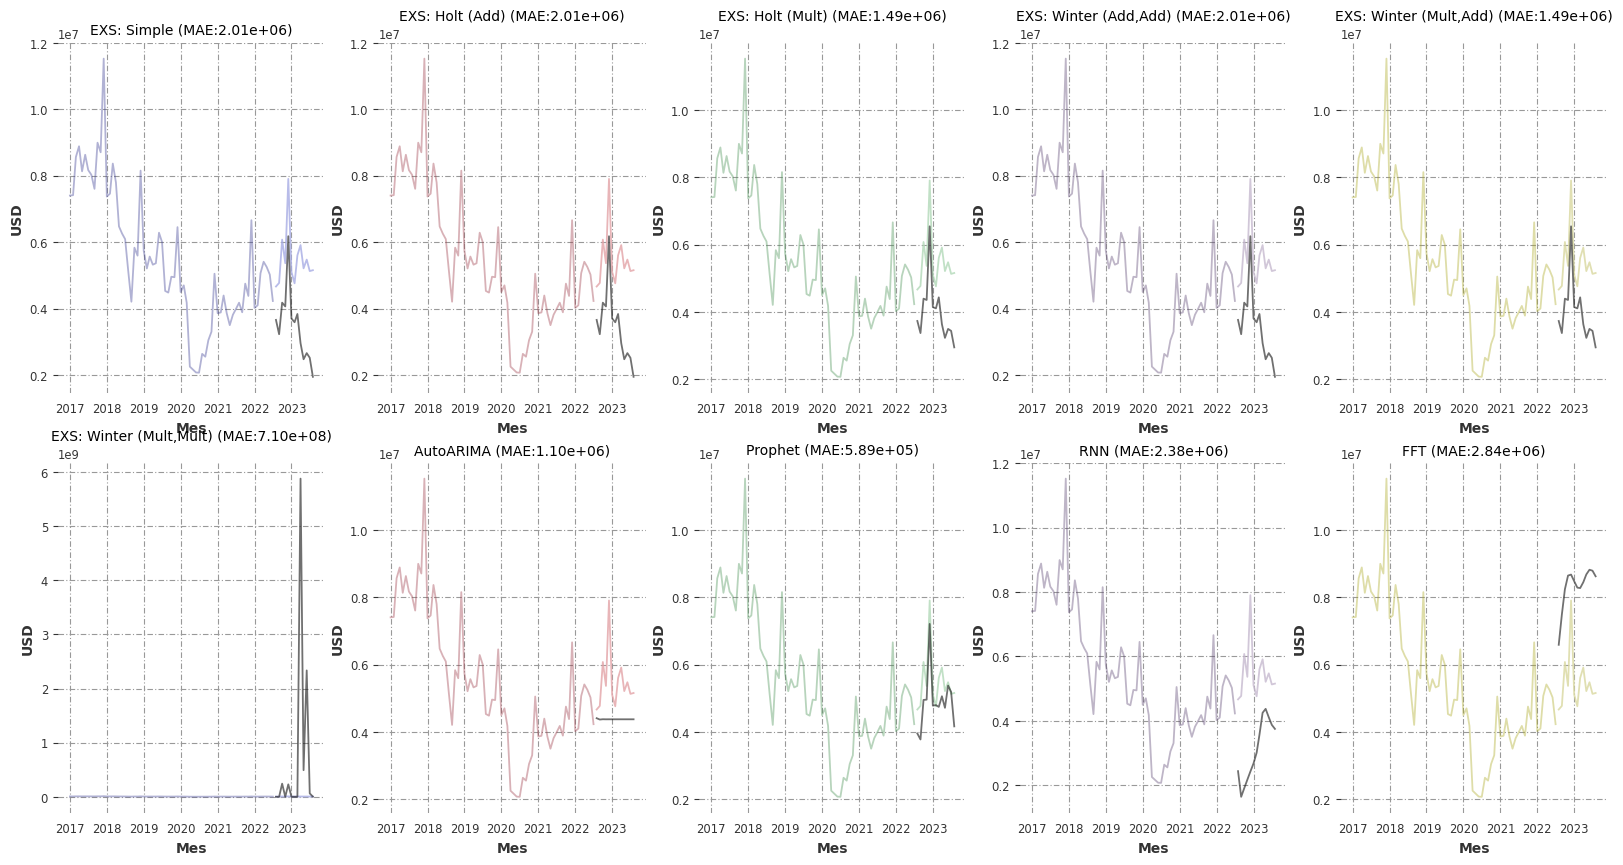

In [11]:
modelos_nombres = [
                'EXS: Simple'
                ,'EXS: Holt (Add)'
                ,'EXS: Holt (Mult)'
                ,'EXS: Winter (Add,Add)'
                ,'EXS: Winter (Mult,Add)'
                ,'EXS: Winter (Mult,Mult)'
                ,'AutoARIMA'
                ,'Prophet'
                ,'RNN'
                ,'FFT'
                ]

p1, axes = plt.subplots(2,5,figsize=(20,10), sharex=False, sharey=False)


for i in range(2):
    for j in range(5):
        axes[i,j].plot(train['y'], color = dark_palette[j], alpha=0.4)
        axes[i,j].plot(test['y'], color = light_palette[j], alpha=0.8)
        axes[i,j].plot(predicciones.iloc[:,i*5+j], color = '#111111', alpha=0.6)
        axes[i,j].set_xlabel('Mes')
        axes[i,j].set_ylabel('USD')
        axes[i,j].set_title(f"{modelos_nombres[i*5+j]} (MAE:{resultados['MAE'][i*5+j]:.2e})")
        axes[i,j].title.set_size(10)
        axes[i,j].grid(True, color='0.6', dashes=(5,2,1,2))

plt.show()